## Portfolio Assignment week 03

## Anomaly Detection 
In machine learning, anomaly detection is the process of discovering patterns or occurrences in a dataset that differ considerably from the norm or expected behavior. Anomalies, also known as outliers, are data points that are uncommon, rare, or do not follow the general patterns observed in the rest of the data. The goal of anomaly detection algorithms is to discover these irregularities automatically. Anomaly detection in machine learning offers a wide range of applications, including predictive maintenance and healthcare monitoring. These algorithms aid in the detection of potential threats by automatically identifying irregularities.

To improve the givin code, we now provide a view option.
I choose to predict the failures in the data using DBSCAN.


## The data
As previously said, the data is made up of sensors that monitor waterpumps in a particular area. The columns in the data represent the sensor itself, and the rows represent the values that the sensor captures.

source : https://www.kaggle.com/datasets/nphantawee/pump-sensor-data . 

I've decided to use DBSCAN to see if the predict rate improves.


In [1]:
# needed modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import yaml


In [2]:
# load the dataset
with open("config.yml") as config:
    input_files = yaml.safe_load(config)
    df = pd.read_csv(input_files["sensor"]).drop('Unnamed: 0', axis=1)
df.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


# Data preparation 

for this step we are going to do a view thing
- NAN values
- shape of data
- value count (state of machine)
- data types 

In [3]:
# Examine the data properties 
amount_na= {}
# check shape
print(f"columns in the dataframe: {df.shape[1]}. Amount of rows {df.shape[0]}.")
print(df.dtypes)
# check na
for col in df.columns:
    amount_na[col] = (df[col].isna().sum() / df.shape[0]) * 100
sorted_amount_na = sorted(amount_na.items(), key=lambda x:x[1], reverse=True)
print(sorted_amount_na)
print(df.machine_status.value_counts())

columns in the dataframe: 54. Amount of rows 220320.
timestamp          object
sensor_00         float64
sensor_01         float64
sensor_02         float64
sensor_03         float64
sensor_04         float64
sensor_05         float64
sensor_06         float64
sensor_07         float64
sensor_08         float64
sensor_09         float64
sensor_10         float64
sensor_11         float64
sensor_12         float64
sensor_13         float64
sensor_14         float64
sensor_15         float64
sensor_16         float64
sensor_17         float64
sensor_18         float64
sensor_19         float64
sensor_20         float64
sensor_21         float64
sensor_22         float64
sensor_23         float64
sensor_24         float64
sensor_25         float64
sensor_26         float64
sensor_27         float64
sensor_28         float64
sensor_29         float64
sensor_30         float64
sensor_31         float64
sensor_32         float64
sensor_33         float64
sensor_34         float64
sensor_35  

The data contains a huge number of NAN values, with sensors 15 and 50 missing almost all of them. 
As a result, we will remove them from the database.

# Plotting (pre predict)
We can now train the model and plot the results. This is all completed prior to predicting the model.
This visualization inspired from JANANI KARIYAWASAM found at
https://www.kaggle.com/code/jananikariyawasam/data-cleaning-and-feature-engineering

In [4]:
# drop these sensors 
df = df.drop(columns=["sensor_15","sensor_50"])
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')

In [5]:
broken_rows = df[df['machine_status']=='BROKEN']
recovery_rows = df[df['machine_status']=='RECOVERING']
normal_rows = df[df['machine_status']=='NORMAL']

def plot_sensor(sensor):
    plot = plt.figure(figsize=(25,3))
    plot = plt.plot(recovery_rows[sensor], linestyle='none', marker='o', color='yellow', markersize=5, label='recovering')
    plot = plt.plot(df[sensor], color='grey')
    plot = plt.plot(broken_rows[sensor], linestyle='none', marker='X', color='red', markersize=14, label = 'broken')
    plot = plt.title(sensor)
    plot = plt.legend()
    plt.show();

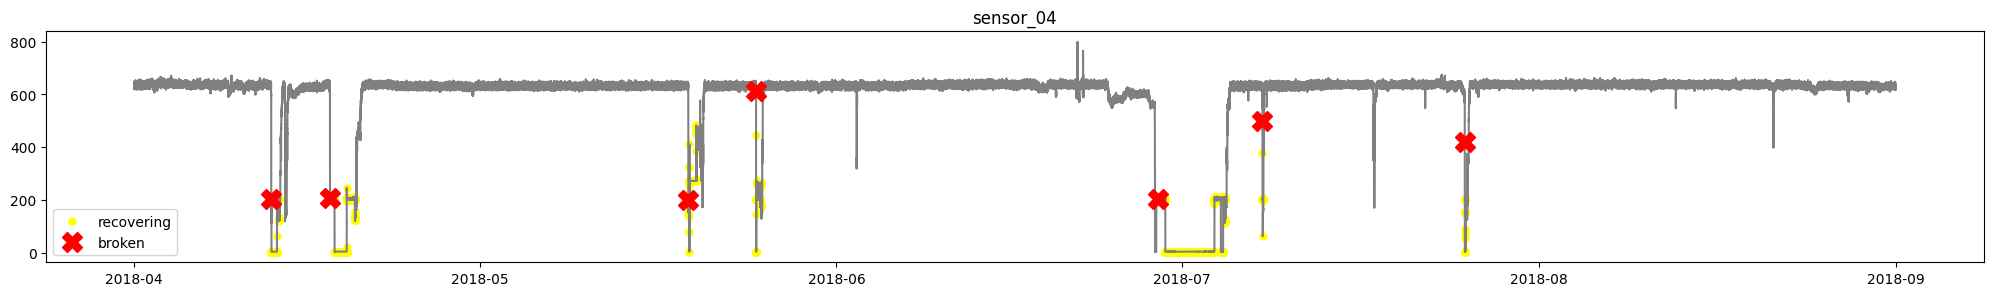

In [6]:
# plot sensor 51
plot_sensor('sensor_04')

# Machine learning with isolation forest (pre tuning)
now we can try to predict the failures in the system using the isolationforest algoritm
The Isolation Forest algorithm selects a feature at random and then selects a split value between the highest and minimum values of that feature at random. This process is performed recursively until a binary tree structure is formed, with each internal node representing a split and each leaf node representing an independent data point. The depth of the tree required to isolate a data point can be used to determine its anomaly.

### Preprocess

In [7]:
# use mean of the column to handle missing values and remove label in feature matrix X
m, n = df.shape
X = df.iloc[:,:n-1] # ignore machine status columns
X = X.fillna(X.mean())
X.shape

(220320, 50)

In [8]:
# scaling the data for use in the algorithm
scaler = StandardScaler()
X = scaler.fit_transform(X)
outliers_fraction = 1 - (len(normal_rows)/(len(df)))



#### Predicting
predicting anomalies with the isolation forest

In [9]:
iso = IsolationForest(contamination=outliers_fraction, n_jobs = -1)
y_pred = iso.fit(X).predict(X)
df["iso_pred"] = y_pred
print("-"*100) # random lines
print(f'number of anomolies detected')
print(df["iso_pred"].value_counts()) # number of anomalies detected with the un stuned version
print("-"*100)

----------------------------------------------------------------------------------------------------
number of anomolies detected
 1    205836
-1     14484
Name: iso_pred, dtype: int64
----------------------------------------------------------------------------------------------------


##### Plotting
Plotting the data with the predicted values

In [10]:
# code is from the notebook `Study_Case_Anomaly_Detection.ipynb`
def plot_sensor_anomolies(sensor,name):
    anomoly_rows = df[df[name] == -1]
    plot = plt.figure(figsize=(25,3))
    plot = plt.plot(df[sensor], color='grey')
    plot = plt.plot(recovery_rows[sensor], linestyle='none', marker='o', color='yellow', markersize=5, label='recovering',alpha = 0.5)
    plot = plt.plot(broken_rows[sensor], linestyle='none', marker='X', color='red', markersize=20, label='broken')
    plot = plt.plot(anomoly_rows[sensor], linestyle='none', marker='X', color='blue', markersize=4, label='anomoly predicted', alpha = 0.1)
    plot = plt.title(sensor)
    plot = plt.legend()
    plt.show();

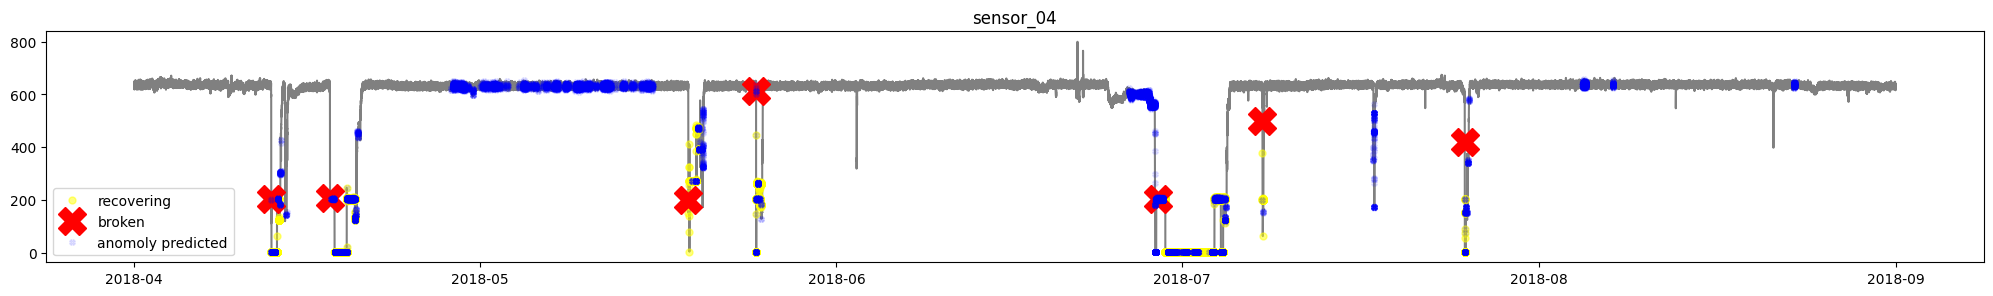

In [11]:
plot_sensor_anomolies('sensor_04','iso_pred')

So, as we can see, the isolation forest can predict very well if there is a fault in the system, but it is not perfect, so we can see if DBSCAN is a better option for this type of work

- DBSCAN: 
        (Density-Based Spatial Clustering of Applications with Noise): DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a density-based clustering technique that may also be used to find anomalies in time series data. While it is primarily a clustering method, its ability to recognize high density areas and classify data points in less dense regions as anomalies qualifies it for anomaly detection jobs.

Reasoning is that DBSCAN is resistant to noise and outliers. DBSCAN is capable of dealing with noisy data and outliers. It labels data points that do not fit into any of the clusters as noise or anomalies. This is especially valuable in anomaly detection jobs, which aim to discover strange or aberrant data points.





# DBSCAN prediction

In [12]:
cluster = DBSCAN(eps=2, min_samples=2) 

In [13]:
y_pred_DBSCAN = cluster.fit_predict(X) 

In [14]:
df["y_pred_DBSCAN"] = y_pred_DBSCAN
print("-"*100) # random lines
print(f'number of anomolies detected')
print(df["y_pred_DBSCAN"].value_counts()) # number of anomalies detected with the un stuned version
print("-"*100)

----------------------------------------------------------------------------------------------------
number of anomolies detected
0      165879
111     19075
203      4210
320      2304
321      1434
        ...  
70          2
264         2
72          2
260         2
216         2
Name: y_pred_DBSCAN, Length: 435, dtype: int64
----------------------------------------------------------------------------------------------------


In [20]:
# code is from the notebook `Study_Case_Anomaly_Detection.ipynb`
def plot_sensor_anomolies(sensor,name):
    anomoly_rows = df[df[name] > 0]
    plot = plt.figure(figsize=(25,3))
    plot = plt.plot(df[sensor], color='grey')
    plot = plt.plot(recovery_rows[sensor], linestyle='none', marker='o', color='yellow', markersize=5, label='recovering',alpha = 0.5)
    plot = plt.plot(broken_rows[sensor], linestyle='none', marker='X', color='red', markersize=20, label='broken')
    plot = plt.plot(anomoly_rows[sensor], linestyle='none', marker='X', color='blue', markersize=4, label='anomoly predicted', alpha = 0.1)
    plot = plt.title(sensor)
    plot = plt.legend()
    plt.show();

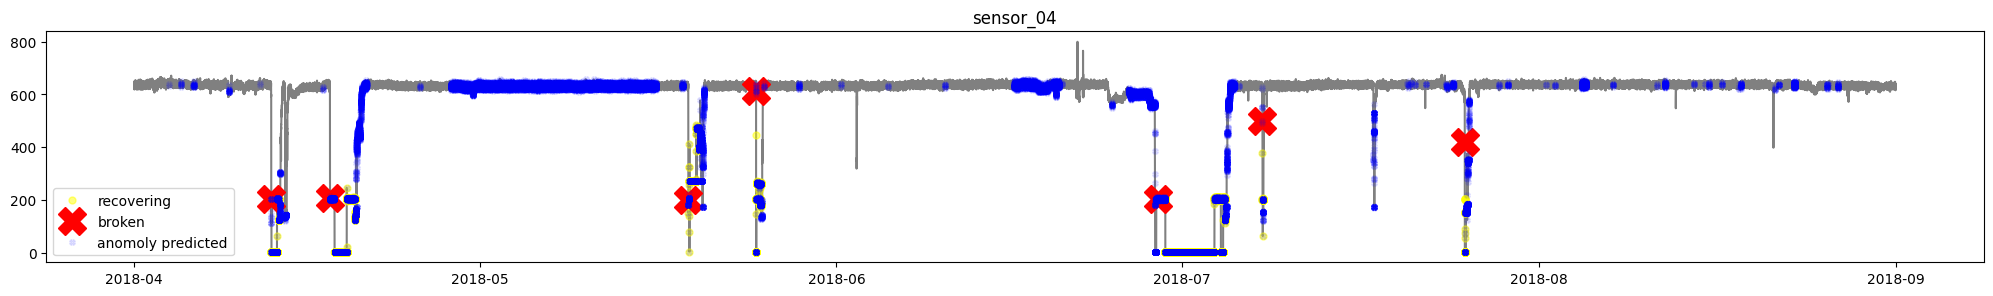

In [21]:
plot_sensor_anomolies('sensor_04','y_pred_DBSCAN')

# Conclsion
DBSCAN is an effective algorithm for detecting failures in this type of data. However, as the figure shows, it also predicts other things.
The algrotim is effective, but it consumes a lot of computing resources. and might therefor not be optimal.